In [11]:
import pyomo.environ as pyo
import numpy as np
import matplotlib.pyplot as plt
from calculations.datahandling import*
from calculations.data_processor import* 

## Initialization

In [12]:
#--Data handling--
#Read of parameters for portfolio
def InputData(data_file):
    inputdata = pd.read_excel(data_file)
    inputdata = inputdata.set_index('Parameter', drop=True)
    inputdata = inputdata.transpose()
    data = {}
    data['hydro'] = inputdata[['yi', 'P_min', 'P_max']].drop('Solar')
    data['solar']=inputdata[['yi', 'P_min', 'P_max']].drop('Hydro1').drop('Hydro2')
    return data

data = InputData('data/Parameters.xlsx')

#--Constants--
Constants= {
    'Load_penalty':200, 
    'Hydro_cap':80, 
    'Load':150,
    'Market':60,
}

scenarios =  {'High':1/3,'Avg':1/3,'Low':1/3}
solar_val_scenario = {'High':30,'Avg':15,'Low':0}

# ----------------------Mathematical formulation ------------------------- #
# ----- First stage obejctive and constraints ------------------ #
def Obj_1st(model):
    return (sum(model.yi[i] * model.p[i] for i in model.plants) - sum(model.Mi[i]*model.p[i] for i in model.plants))/len(scenarios) + model.alpha #minimize(power produced - power sold to market)

def p_bounds(model,i):
    return (model.Pmin[i], model.Pmax[i])   

def Hydro_capacity(model, i):
    return model.p[i] <= model.H_stage1[i]

def CreateCuts(model,c):
    return(model.alpha >= model.Phi[c] - sum(model.Lambda[c,i]*(model.p[i]-model.x_hat[c,i]) for i in model.plants))  #only takes into account the hydro power production scheduling from H_cap

# ----- Second stage ojbective and constraints --------------#
def Obj_2nd(model):
    return (model.probs*(sum(model.yi[i]*model.p[i] for i in model.plants) + (model.Li * model.L_p)))


#def Solar_rule(model):
    #return model.phi == Solar_p

def Hydro_capacity2(model, i):      #ensures that model.p does not use more capacity than what it has available
    return model.p[i] <= model.H_stage2[i]

def load_rule(model):
    return model.p['Hydro1'] + model.p['Hydro2'] + model.phi == model.L - model.L_p 

def calculate_initial_H_stage2(Constants, X_hat):
    initial_H_stage2 = {}
    for plant in X_hat:
        remaining_capacity = Constants['Hydro_cap'] - (X_hat[plant])
        initial_H_stage2[plant] = remaining_capacity
    return initial_H_stage2
 
# ------------------------- MODEL SETUP -------------------------- #

# Set up model 1st stage
def ModelSetUp_1st(data, Constants,Cuts, Scenario):
    model = pyo.ConcreteModel()

    # Define sets and parameters specific to the first stage
    model.plants   =  pyo.Set(initialize=data['hydro'].index)  # Set of plant types (e.g., 'Hydro1', 'Hydro2')

    #Parameters
    model.yi       =  pyo.Param(model.plants, initialize=data['hydro']['yi'])
    model.Pmin     =  pyo.Param(model.plants, initialize=data['hydro']['P_min'])
    model.Pmax     =  pyo.Param(model.plants, initialize=data['hydro']['P_max'])
    model.H_stage1 =  pyo.Param(model.plants, initialize=Constants['Hydro_cap'])                        #Initial capacity
    model.Mi       =  pyo.Param(model.plants, initialize=Constants['Market'])                           #Market sell price
    model.L        =  pyo.Param(initialize=Constants['Load'])
    model.probs    =  pyo.Param(initialize=Scenario)

    # Variables
    model.p        =  pyo.Var(model.plants, bounds=p_bounds)  # Production from hydro plants

    # Constraints
    model.hydro_cons   =  pyo.Constraint(model.plants, rule=Hydro_capacity)

    # Cuts information
    model.Cut      =  pyo.Set(initialize = Cuts["Set"])
    model.Phi      =  pyo.Param(model.Cut, initialize = Cuts["Phi"])
    model.Lambda   =  pyo.Param(model.Cut, model.plants, initialize = Cuts["lambda"])
    model.x_hat    =  pyo.Param(model.Cut, model.plants, initialize = Cuts["x_hat"])
    
    model.alpha    =  pyo.Var(bounds = (-10000,10000))
    
    model.CreateCuts   =  pyo.Constraint(model.Cut, rule = CreateCuts)

    # Define objective function
    model.obj      =  pyo.Objective(rule=Obj_1st, sense=pyo.minimize)
    
    return model

def ModelSetUp_2nd(data, Constants, X_hat, rem_cap, Solar, Scenario):
    # Instance
    model          =  pyo.ConcreteModel()

    # Define sets
    model.plants   =  pyo.Set(initialize=data['hydro'].index)  # Set of plant types (e.g., 'Hydro1', 'Hydro2')

    # Define parameters
    model.X_hat    =  pyo.Param(model.plants, initialize=X_hat)
    model.Li       =  pyo.Param(initialize=Constants['Load_penalty']) 
    model.yi       =  pyo.Param(model.plants, initialize=data['hydro']['yi'])
    model.Pmin     =  pyo.Param(model.plants, initialize=data['hydro']['P_min'])
    model.Pmax     =  pyo.Param(model.plants, initialize=data['hydro']['P_max'])
    model.H_stage2 =  pyo.Param(model.plants, initialize=rem_cap)
    model.L        =  pyo.Param(initialize=Constants['Load'])
    model.probs    =  pyo.Param(initialize=Scenario)
    model.phi      =  pyo.Param(initialize=Solar)

    # Define variables
    model.p        =  pyo.Var(model.plants, bounds=p_bounds)
    #model.phi      =  pyo.Var(within=pyo.NonNegativeReals)
    model.L_p      =  pyo.Var(within=pyo.NonNegativeReals)

    # Constraints
    model.load_cons    =  pyo.Constraint(rule=load_rule)
    #model.solar_cons   =  pyo.Constraint(rule=Solar_rule)
    model.hydro_cons   =  pyo.Constraint(model.plants, rule=Hydro_capacity2)                                           #constraining power production from hydrom from the remaining capacity

    # Define objective function
    model.obj     =  pyo.Objective(rule=Obj_2nd, sense=pyo.minimize)
    
    return model


def Solve(model):
    opt = pyo.SolverFactory("gurobi")
    model.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)
    results = opt.solve(model, load_solutions=True)
    return results, model


def DisplayResults(model):
    return print(model.display(), model.dual.display())


# ----------------------- CUTTING ------------------------ #

# Function for creating new linear cuts for optimization problem
def Cut_manage(Cuts,model):
    """Add new cut to existing dictionary of cut information"""
    
    #Find cut iteration by checking number of existing cuts
    cut = len(Cuts["Set"])
    #Add new cut to list, since 0-index is a thing this works well
    Cuts["Set"].append(cut)
    
    #Find 2nd stage cost result
    Cuts["Phi"][cut] = pyo.value(model.obj)
    #Find lambda x_hat for each type of power produced
    for i in model.plants:
        Cuts["lambda"][cut, i] = model.dual.get(model.hydro_cons[i])  # the lambda should be the economic change when we increase the 1st decision by 1. Should be something else
        Cuts["x_hat"][cut,i] = model.X_hat[i]
    return(Cuts)




## Bender's decomposition

In [13]:
# Initialize empty value for accumulated objective value from all scenarios
tot_1st = 0

# Empty lists to store results from each scenario for plotting later
hydro1_st1 = []
hydro2_st1 = []
hydro1_st2 = []
hydro2_st2 = []
result_phi = []
result_L_p = []
UB = []
LB = []

# Loop over all scenarios
for s in scenarios:
    print()
    print('----------------------------------------------------------------------------------')
    print("Solving for scenario:",s)
    print('----------------------------------------------------------------------------------')
    Solar_p = solar_val_scenario[s]  #input of solar data to be used in the optimization
    print("The amount of solar power for scenario",s,"is:",Solar_p,"MW")
    tol = 1
    i = 0

    opt = pyo.SolverFactory("gurobi")
    
    UB_inner = []
    LB_inner = []
    
    Cuts = {}
    Cuts["Set"] = []
    Cuts["Phi"] = {}
    Cuts["lambda"] = {}
    Cuts["x_hat"] = {}

    while abs(tol) > 0.1:
        i += 1
        print()
        print('Solving for iteration:',i)
        print()

        #Solve 1st stage problem
        m_1st = ModelSetUp_1st(data, Constants, Cuts, Scenario=scenarios[s])
        Solve(m_1st)

        # Process 1st stage result
        X_hat = {
                "Hydro1": m_1st.p["Hydro1"].value,
                "Hydro2": m_1st.p["Hydro2"].value,
            }
        
        display("How much capacity was used by each plant in stage 1 after solving iteration: "  +  str( i ) + "  " + str(X_hat))

        #Updating remaining capacity between stages
        initial_H_stage2 = calculate_initial_H_stage2(Constants, X_hat)         #calculate changing capacity between stages
        display("How much capacity is left for each plant in stage 2 after solving iteration: "  +  str( i ) + "  " + str(initial_H_stage2))

        # Setup and solve 2nd stage problem with updated amount of capacity left
        m_2nd = ModelSetUp_2nd(data, Constants, X_hat, initial_H_stage2, Solar_p, Scenario=scenarios[s])
        Solve(m_2nd)

        #Create new cuts for 1st stage problem
        Cuts = Cut_manage(Cuts,m_2nd)

        #Print results 2nd stage
        print("Objective function - Second stage:",pyo.value(m_2nd.obj()))

        tol = (pyo.value(m_1st.alpha.value)-pyo.value(m_2nd.obj()))
        print("TOLERANCE",abs(tol))

        #Convergence check
        print("UB:",pyo.value(m_2nd.obj()),"- LB:",pyo.value(m_1st.alpha.value))
        UB_inner.append(pyo.value(m_2nd.obj()))
        LB_inner.append(pyo.value(m_1st.alpha.value))
        print("The first stage objective value is:",m_1st.obj())

    print("")
    print('--------------------------------->','For scenario:',s,'the cost is:',m_1st.obj(),'<---------------------------------')
    print("")

    #Total costs is the objectiv value of the final iterated first stage including the alpha value derived from the final iterated second stage
    tot_1st += m_1st.obj() 

    hydro1_st1.append(m_1st.p['Hydro1'].value)
    hydro2_st1.append(m_1st.p['Hydro2'].value)

    hydro1_st2.append(m_2nd.p['Hydro1'].value)
    hydro2_st2.append(m_2nd.p['Hydro2'].value)
    result_phi.append(m_2nd.phi.value)
    result_L_p.append(m_2nd.L_p.value)
    UB.append(UB_inner)
    LB.append(LB_inner) 

print(">>>>-------------------------------------<<<<")
print("The objective value is:",np.round(tot_1st,2))
print(">>>>-------------------------------------<<<<")


----------------------------------------------------------------------------------
Solving for scenario: High
----------------------------------------------------------------------------------
The amount of solar power for scenario High is: 30 MW

Solving for iteration: 1



"How much capacity was used by each plant in stage 1 after solving iteration: 1  {'Hydro1': 60.0, 'Hydro2': 80.0}"

"How much capacity is left for each plant in stage 2 after solving iteration: 1  {'Hydro1': 20.0, 'Hydro2': 0.0}"

Objective function - Second stage: 6833.333333333333
TOLERANCE 16833.333333333332
UB: 6833.333333333333 - LB: -10000.0
The first stage objective value is: -11366.666666666666

Solving for iteration: 2



"How much capacity was used by each plant in stage 1 after solving iteration: 2  {'Hydro1': 0.0, 'Hydro2': 0.0}"

"How much capacity is left for each plant in stage 2 after solving iteration: 2  {'Hydro1': 80.0, 'Hydro2': 80.0}"

Objective function - Second stage: 1200.0
TOLERANCE 2266.6666666666642
UB: 1200.0 - LB: -1066.6666666666642
The first stage objective value is: -1066.6666666666642

Solving for iteration: 3



"How much capacity was used by each plant in stage 1 after solving iteration: 3  {'Hydro1': 38.85714285714283, 'Hydro2': 0.0}"

"How much capacity is left for each plant in stage 2 after solving iteration: 3  {'Hydro1': 41.14285714285717, 'Hydro2': 80.0}"

Objective function - Second stage: 1262.8571428571427
TOLERANCE 62.85714285714266
UB: 1262.8571428571427 - LB: 1200.0
The first stage objective value is: 746.666666666667

Solving for iteration: 4



"How much capacity was used by each plant in stage 1 after solving iteration: 4  {'Hydro1': 39.99999999999997, 'Hydro2': 0.0}"

"How much capacity is left for each plant in stage 2 after solving iteration: 4  {'Hydro1': 40.00000000000003, 'Hydro2': 80.0}"

Objective function - Second stage: 1266.666666666667
TOLERANCE 9.094947017729282e-13
UB: 1266.666666666667 - LB: 1266.666666666666
The first stage objective value is: 799.9999999999998

---------------------------------> For scenario: High the cost is: 799.9999999999998 <---------------------------------


----------------------------------------------------------------------------------
Solving for scenario: Avg
----------------------------------------------------------------------------------
The amount of solar power for scenario Avg is: 15 MW

Solving for iteration: 1



"How much capacity was used by each plant in stage 1 after solving iteration: 1  {'Hydro1': 60.0, 'Hydro2': 80.0}"

"How much capacity is left for each plant in stage 2 after solving iteration: 1  {'Hydro1': 20.0, 'Hydro2': 0.0}"

Objective function - Second stage: 7833.333333333333
TOLERANCE 17833.333333333332
UB: 7833.333333333333 - LB: -10000.0
The first stage objective value is: -11366.666666666666

Solving for iteration: 2



"How much capacity was used by each plant in stage 1 after solving iteration: 2  {'Hydro1': 0.0, 'Hydro2': 0.0}"

"How much capacity is left for each plant in stage 2 after solving iteration: 2  {'Hydro1': 80.0, 'Hydro2': 80.0}"

Objective function - Second stage: 1375.0
TOLERANCE 1441.6666666666642
UB: 1375.0 - LB: -66.66666666666424
The first stage objective value is: -66.66666666666424

Solving for iteration: 3



"How much capacity was used by each plant in stage 1 after solving iteration: 3  {'Hydro1': 24.71428571428569, 'Hydro2': 0.0}"

"How much capacity is left for each plant in stage 2 after solving iteration: 3  {'Hydro1': 55.285714285714306, 'Hydro2': 80.0}"

Objective function - Second stage: 1390.7142857142856
TOLERANCE 15.714285714285552
UB: 1390.7142857142856 - LB: 1375.0
The first stage objective value is: 1086.666666666667

Solving for iteration: 4



"How much capacity was used by each plant in stage 1 after solving iteration: 4  {'Hydro1': 24.999999999999975, 'Hydro2': 0.0}"

"How much capacity is left for each plant in stage 2 after solving iteration: 4  {'Hydro1': 55.00000000000003, 'Hydro2': 80.0}"

Objective function - Second stage: 1391.666666666667
TOLERANCE 9.094947017729282e-13
UB: 1391.666666666667 - LB: 1391.666666666666
The first stage objective value is: 1099.9999999999998

---------------------------------> For scenario: Avg the cost is: 1099.9999999999998 <---------------------------------


----------------------------------------------------------------------------------
Solving for scenario: Low
----------------------------------------------------------------------------------
The amount of solar power for scenario Low is: 0 MW

Solving for iteration: 1



"How much capacity was used by each plant in stage 1 after solving iteration: 1  {'Hydro1': 60.0, 'Hydro2': 80.0}"

"How much capacity is left for each plant in stage 2 after solving iteration: 1  {'Hydro1': 20.0, 'Hydro2': 0.0}"

Objective function - Second stage: 8833.333333333332
TOLERANCE 18833.333333333332
UB: 8833.333333333332 - LB: -10000.0
The first stage objective value is: -11366.666666666666

Solving for iteration: 2



"How much capacity was used by each plant in stage 1 after solving iteration: 2  {'Hydro1': 0.0, 'Hydro2': 0.0}"

"How much capacity is left for each plant in stage 2 after solving iteration: 2  {'Hydro1': 80.0, 'Hydro2': 80.0}"

Objective function - Second stage: 2100.0
TOLERANCE 1166.666666666666
UB: 2100.0 - LB: 933.3333333333339
The first stage objective value is: 933.3333333333339

Solving for iteration: 3



"How much capacity was used by each plant in stage 1 after solving iteration: 3  {'Hydro1': 19.999999999999993, 'Hydro2': 0.0}"

"How much capacity is left for each plant in stage 2 after solving iteration: 3  {'Hydro1': 60.00000000000001, 'Hydro2': 80.0}"

Objective function - Second stage: 2100.0
TOLERANCE 0.0
UB: 2100.0 - LB: 2100.0
The first stage objective value is: 1866.6666666666667

---------------------------------> For scenario: Low the cost is: 1866.6666666666667 <---------------------------------

>>>>-------------------------------------<<<<
The objective value is: 3766.67
>>>>-------------------------------------<<<<


### Plotting power production schedule

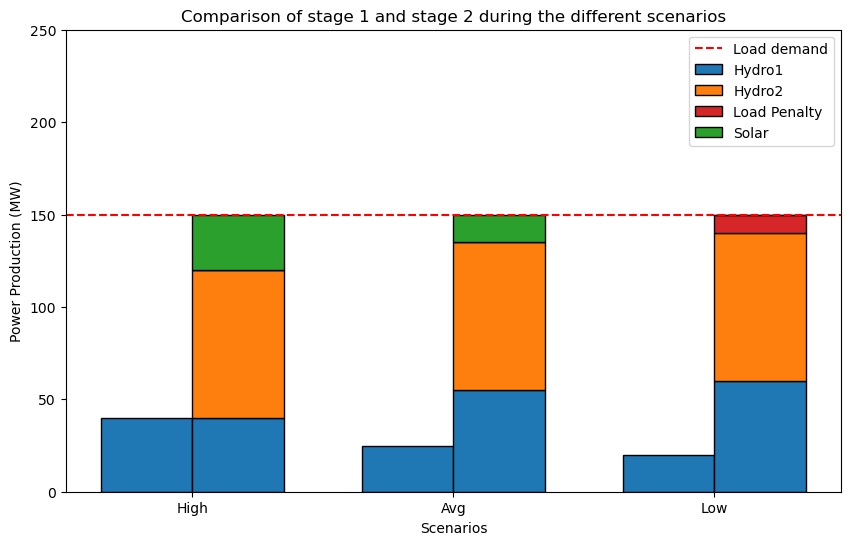

In [14]:
# Data from Bender's decomposition
hydro1_st1 = np.array(hydro1_st1)
hydro1_st2 = np.array(hydro1_st2)
hydro2_st2 = np.array(hydro2_st2)
result_L_p = np.array(result_L_p)
result_phi = np.array(result_phi)

plt.figure(figsize=(10, 6))
bar_width = 0.35
bar_positions_1st = np.arange(len(scenarios)) 
bar_positions_2nd = bar_positions_1st + bar_width 

plt.bar(bar_positions_1st, hydro1_st1, width=bar_width, label=f'Hydro1', color='C0', edgecolor ='black')
plt.bar(bar_positions_2nd, hydro1_st2, width=bar_width, color="C0", edgecolor ='black')
plt.bar(bar_positions_2nd, hydro2_st2, width=bar_width, bottom=hydro1_st2, label=f'Hydro2', color='C1', edgecolor='black')
plt.bar(bar_positions_2nd, result_L_p, width=bar_width, bottom=hydro1_st2 + hydro2_st2, label=f'Load Penalty', color="C3", edgecolor='black')
plt.bar(bar_positions_2nd, result_phi, width=bar_width, bottom=hydro1_st2 + hydro2_st2 + result_L_p, label=f'Solar', color='C2', edgecolor='black')
plt.axhline(y=150, color='red', linestyle='--', label='Load demand')
plt.xlabel('Scenarios')
plt.ylabel('Power Production (MW)')
plt.ylim(0, 250)
plt.title('Comparison of stage 1 and stage 2 during the different scenarios')
plt.xticks(bar_positions_1st + bar_width / 2, scenarios)
plt.legend(loc="upper right")
plt.show()

### Plotting convergence

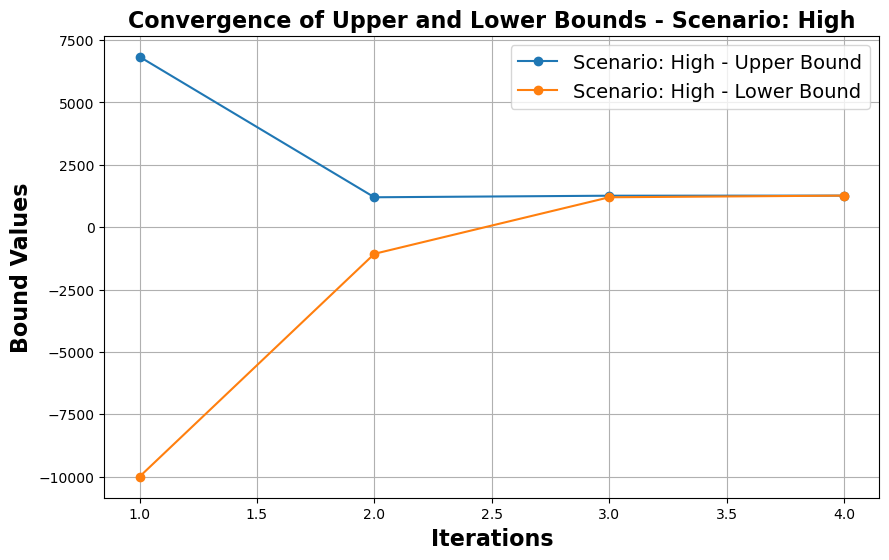

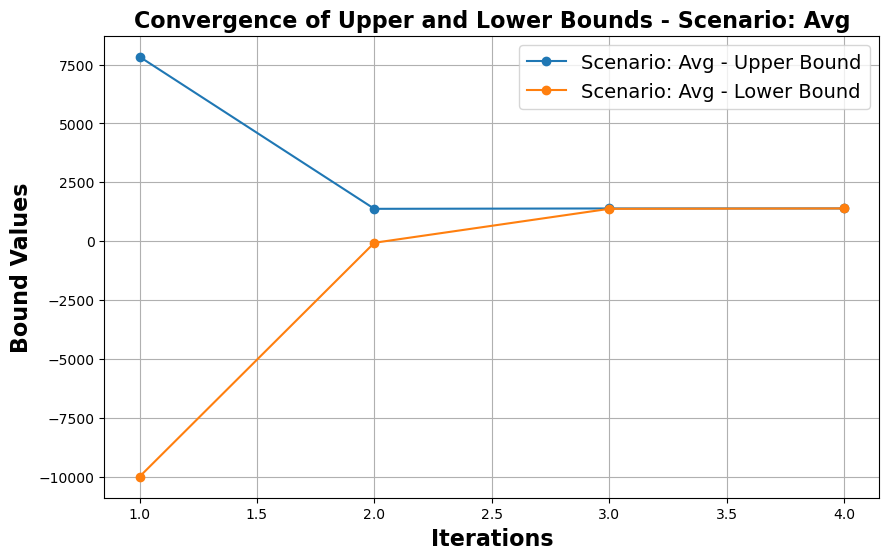

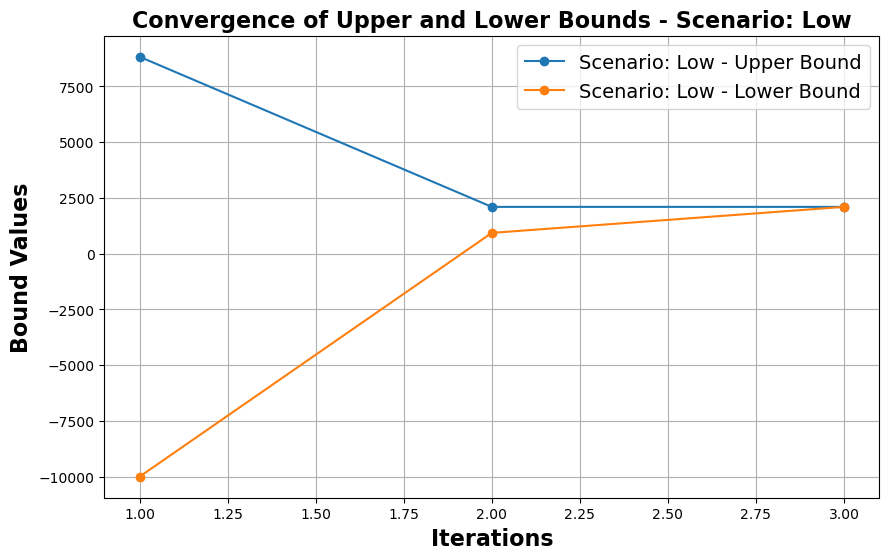

In [15]:
# Data from the bounds
iterations = [range(1,len(UB[0])+1,1),range(1,len(UB[1])+1,1),range(1,len(UB[2])+1,1)]
upper_bounds = UB
lower_bounds = LB

# Plotting for each scenario
for i, scenario in enumerate(scenarios):
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(iterations[i], upper_bounds[i], label=f'Scenario: {scenario} - Upper Bound', marker='o')
    ax.plot(iterations[i], lower_bounds[i], label=f'Scenario: {scenario} - Lower Bound', marker='o')

    ax.set_xlabel('Iterations', fontsize=16, fontweight='bold')
    ax.set_ylabel('Bound Values', fontsize=16, fontweight='bold')
    ax.legend(fontsize=14)
    ax.grid(True)
    plt.title(f'Convergence of Upper and Lower Bounds - Scenario: {scenario}', fontsize=16, fontweight='bold')

    plt.show()
    
# Due to convergence, all the variables need to be reset at the end (NOTE THAT EVERYTHING IS RESET, INDIVIDUAL CELLS WILL NOT WORK UNLESS EVERYTHING IS RUN AGAIN)
%reset -f